## Imports

In [1]:
import numpy as np
from numpy import sqrt, random as rm
import matplotlib.pyplot as plt
import statsmodels.api as sm

## Arithmetic Brownian Motion

$$ dX_t = \mu dt + \sigma dW_t$$
Euler discretised
$$ dX_t =  \mu dt + \sigma\sqrt{dt}\phi$$
Analytical Solution
$$ X_t = X_0 + \mu t + \sigma W_t$$

In [84]:
T = 1
n = 200
dt = T/n
paths = 2000
x = np.linspace(0,1,n)
mu = -0.5
sigma = 0.4

dx = mu*dt + sigma*np.sqrt(dt)*np.random.randn(n, paths)
abm = np.cumsum(dx, axis=0)

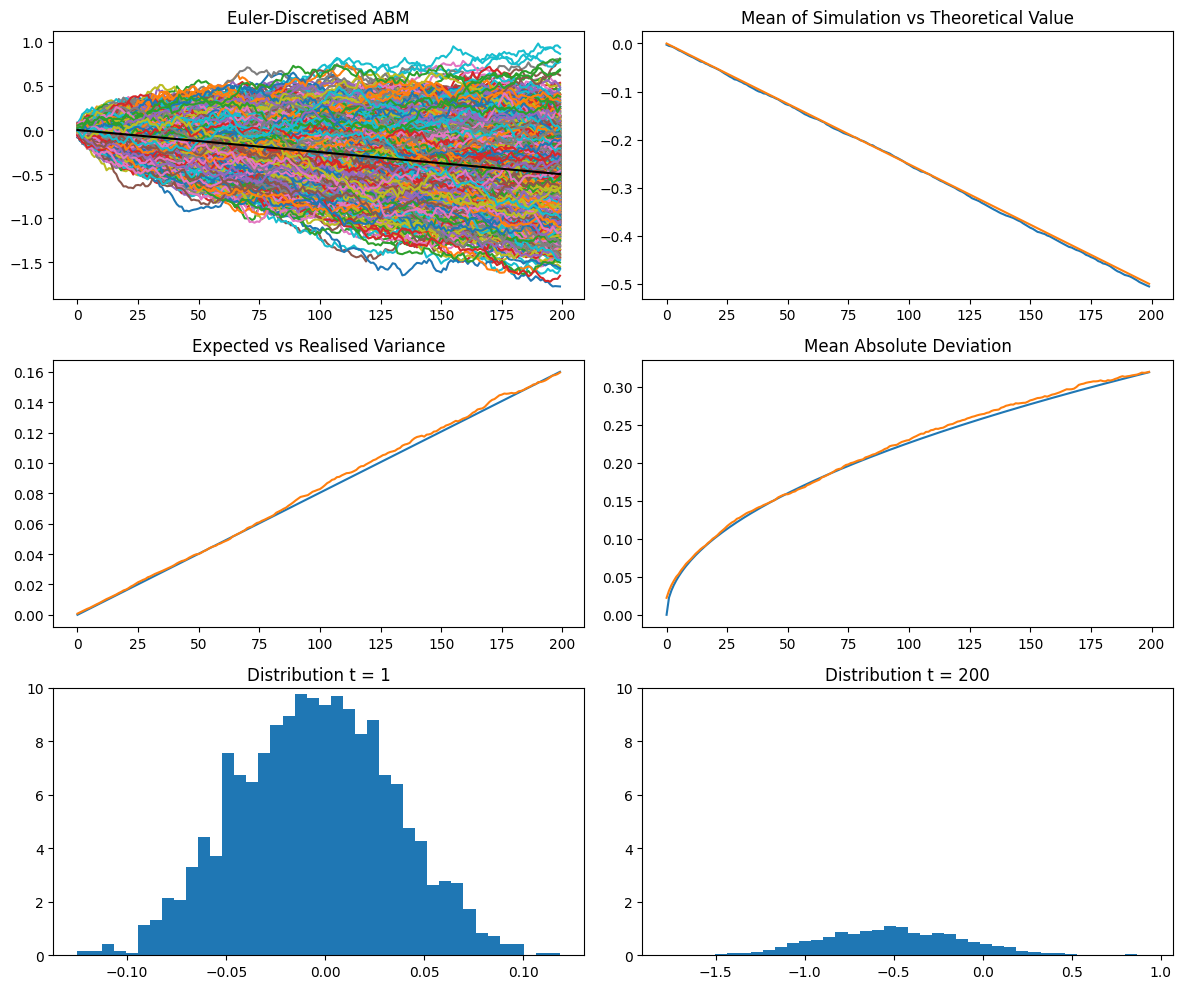

In [94]:
fig, axes = plt.subplots(3,2, figsize=(12,10), tight_layout=True)
axes[0,0].set_title("Euler-Discretised ABM")
axes[0,0].plot(abm)
axes[0,0].plot(x*mu, color="black")

axes[0,1].plot(abm.mean(axis=1))
axes[0,1].plot(x*mu)
axes[0,1].set_title("Mean of Simulation vs Theoretical Value")

axes[1,0].set_title("Expected vs Realised Variance")
axes[1,0].plot(sigma**2*x)
axes[1,0].plot(abm.var(axis=1))

axes[1,1].plot(sigma*np.sqrt(2*x/np.pi))
mad = np.mean(np.abs(abm - np.mean(abm, axis=1, keepdims=True)), axis=1)
axes[1,1].plot(mad)
axes[1,1].set_title("Mean Absolute Deviation")

axes[2,0].hist(abm[1, :], density=True, bins=40)
axes[2,0].set_ylim([0,10])
axes[2,0].set_title("Distribution t = 1")
axes[2,1].hist(abm[-1, :], density=True, bins=40)
axes[2,1].set_ylim([0,10])
axes[2,1].set_title("Distribution t = 200")

plt.show()

## GBM

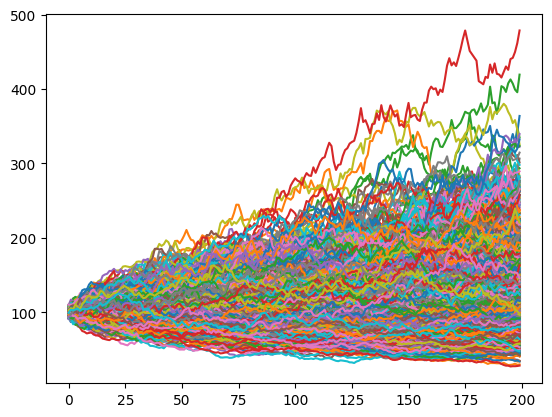

In [92]:
mu_gbm = 0.2
mu_abm = mu_gbm - 0.5*sigma**2
S_0 = 100

dx = mu_abm*dt + sigma*np.sqrt(dt)*np.random.randn(n, paths)
inc = np.cumsum(dx, axis=0)
S = S_0*np.exp(inc)
plt.plot(S)
plt.show()

## Ornstein-Uhlenbeck Process

$$dX_t = \alpha(\mu - X_t)dt + \sigma dW_t$$

In [170]:
T = 1
n = 200
dt = T/n
paths = 2000
x_grid = np.linspace(0,1,n)
alpha = 5
mu = 0.05
sigma = 0.04
X_0 = 0.02
X = np.empty((n, paths))
X[0, :] = X_0
norm = np.random.randn(n, paths)
std = sigma*np.sqrt(dt)
#std = sigma*np.sqrt((1-np.exp(-2*alpha*dt))/(2*alpha))

for i in range(1,n):
    X[i, :] = X[i-1, :] + alpha*(mu - X[i-1, :])*dt + std*norm[i, :]

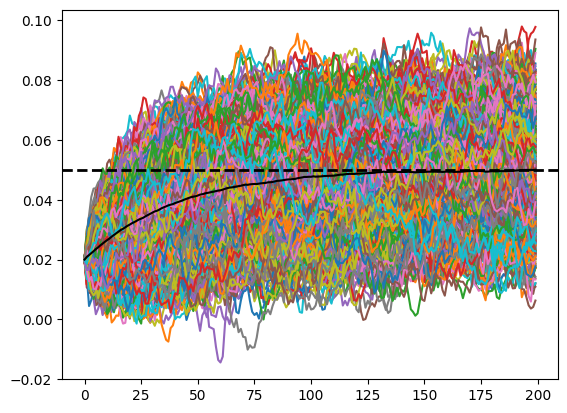

In [171]:
plt.plot(X)
plt.plot(X.mean(axis=1), color="black")
plt.axhline(mu, color="black", ls="dashed", lw=2)
plt.show()

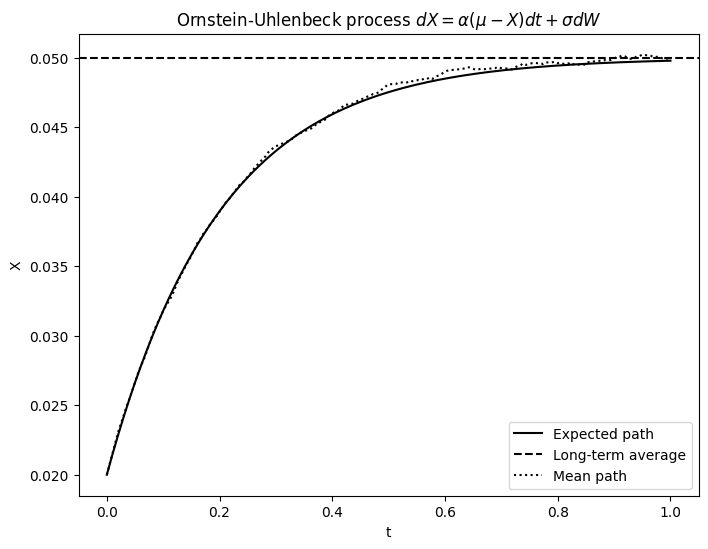

In [130]:
EX = mu + (X_0 - mu) * np.exp(-alpha * x_grid)

# Plot
plt.figure(figsize=(8, 6))

plt.plot(x_grid, EX, 'k', label='Expected path')
plt.axhline(mu, ls='--', label='Long-term average', color="black")
plt.plot(x_grid, np.mean(X, axis=1), 'k:', label='Mean path')

plt.legend()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Ornstein-Uhlenbeck process $dX = \\alpha(\\mu - X)dt + \\sigma dW$')
plt.show()

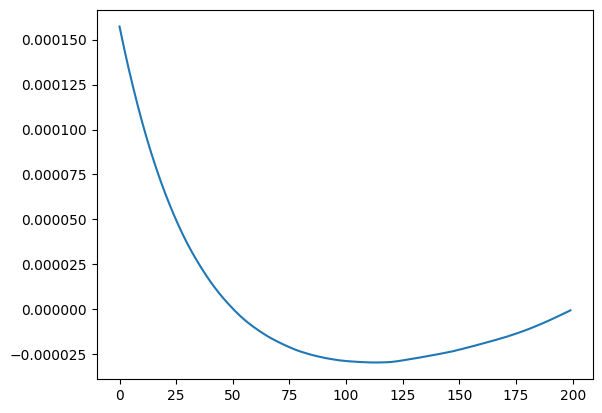

In [157]:
from statsmodels.tsa.stattools import  acovf
acov_mat = acovf(X[:,0])

for i in range(1,paths):
    acov_mat = np.vstack([acov_mat, acovf(X[:,i])])

acov_mat = acov_mat.T
plt.plot(acov_mat.mean(axis=1))
plt.show()

## Feller-Square Root Process and Vasicek Model

$$ dX_t = \alpha(\mu - X_t)dt + \sigma\sqrt{X_t}dW_t $$

In [257]:
npaths = 20
T = 1
nsteps = 200
dt = T/nsteps
t = np.linspace(0,T,nsteps)
sigma = 0.265
mu = 0.07
alpha = 5
X_0 = 0.3
Feller_ratio = 2*alpha*mu/sigma**2

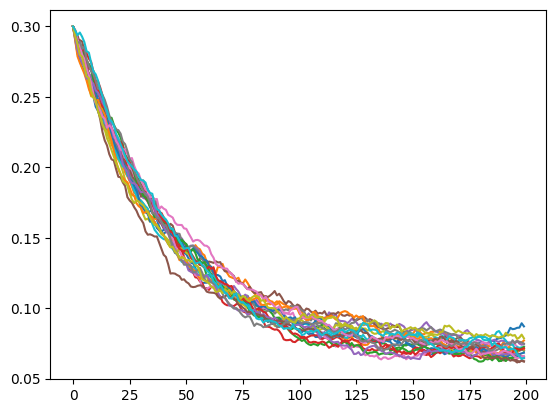

In [268]:
# Euler-Maruyama
N = np.random.normal(size=(nsteps, npaths))
a = (sigma**2/alpha)*(np.exp(-alpha*dt)-np.exp(-2*alpha*dt))
b = (mu*sigma**2)/(2*alpha)*(1-np.exp(-alpha*dt))**2

X = np.empty(shape=(nsteps, npaths))
X[0,:] = X_0

for i in range(nsteps-1):
    X[i+1,:] = X[i,:] + alpha*(mu - X[i,:])*dt + sigma*np.sqrt(a*X[i,:]+b)*N[i,:]
    # X(i+1,:) = mu+(X(i,:)-mu)*exp(-alpha*dt) + sqrt(a*X(i,:)+b).*N(i,:); % with analytic moments
    X[i+1,:] = np.maximum(X[i+1,:], 0)

plt.plot(X)
plt.show()

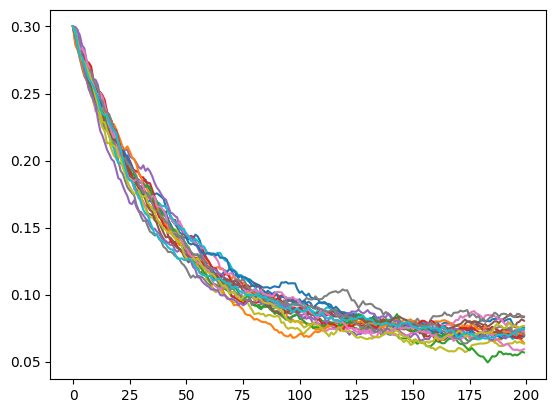

In [266]:
# Exact Method
d = 4*alpha*mu/sigma**2 # degrees of freedom of the non-central chi square distribution
k = sigma**2*(1-np.exp(-alpha*dt))/(4*alpha)
for i in range(nsteps-1):
   lam = 4*alpha*X[i,:]/(sigma**2*(np.exp(alpha*dt)-1))
   # ncx2 = non-central chi-squared.
   X[i+1,:] = icdf('ncx2',np.random.normal(size=(1,npaths)),d,lam)*k  # 80000 times slower than EM
   X[i+1,:] = ncx2rnd(d,lam,1,npaths)*k # 40 times slower than EM.

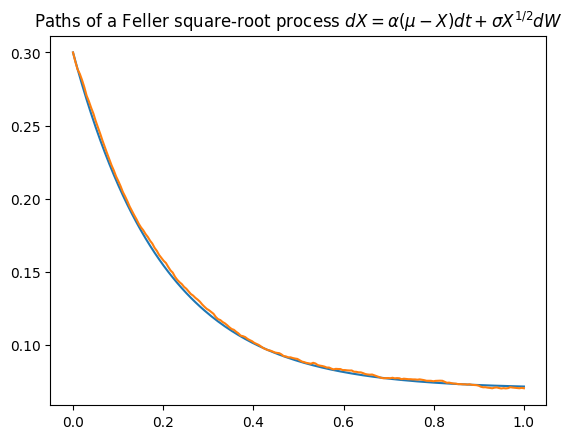

In [276]:
# Expected, mean and sample paths.
EX = mu + (X_0-mu)*np.exp(-alpha*t)
plt.plot(t, EX)
plt.plot(t, np.mean(X, axis=1))
sdevinfty = sigma*np.sqrt(mu/(2*alpha))
plt.title("Paths of a Feller square-root process $dX = \\alpha(\\mu-X)dt + \\sigma X^{1/2}dW$")
plt.show()

In [ ]:
# Probability density function at different times.
from scipy.stats import ncx2
t2 = [0.05, 0.1, 0.2, 0.4, 1]
x = np.linspace(-0.02,mu+4*sdevinfty,200)
k = sigma**2*(1-np.exp(-alpha*t2))/(4*alpha)
d = 4*alpha*mu/sigma**2
lam = 4*alpha*X_0/(sigma**2*(np.exp(alpha*t2)-1)) # Non-centrality parameter
fa = np.zeros(shape=(len(x),len(t2))) # analytical
fs = np.zeros(shape=(len(x),len(t2))) # sampled
for i in range(len(t2)):
    fa[:,i] = ncx2(x/k,d,lam)/k
    #fs[:,i] = hist(X(t2(i)*nsteps,:),x)/(npaths*(x(2)-x(1)))

## Brownian Bridge

$$ dX_t = \frac{b - X_t}{T - t}dt + dW_t $$

In [288]:
npaths = 2000
T = 1
nsteps = 200
dt = T/nsteps
t = np.linspace(0,T,nsteps)
sigma = 0.3
a = 0.8
b = 1

In [289]:
X = np.empty(shape=(nsteps, npaths))
X[0,:] = a

# Compute the Brownian bridge with Euler-Maruyama

for i in range(nsteps-1):
    X[i+1,:] = X[i,:] + (b-X[i,:])/(nsteps-i+1) + sigma*np.random.normal(size=(1,npaths))*np.sqrt(dt)

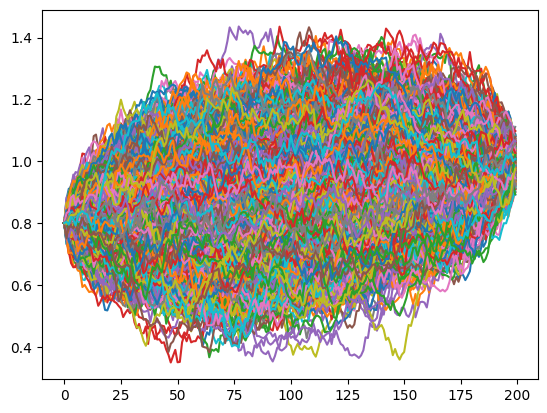

In [291]:
plt.plot(X)
plt.show()

In [311]:
# Monte Carlo method 2
# Compute the increments of driftless arithmetic Brownian motion
dW = sigma*np.random.normal(size=(nsteps,npaths))*sqrt(dt)
dW[0,:] = a
# Accumulate the increments of arithmetic Brownian motion
W = np.cumsum(dW, axis=0)

# Compute the Brownian bridge with X(t) = W(t) + (b-W(T))/T*t
X = W + (b - W[-1, :]) / T * t[:, np.newaxis]

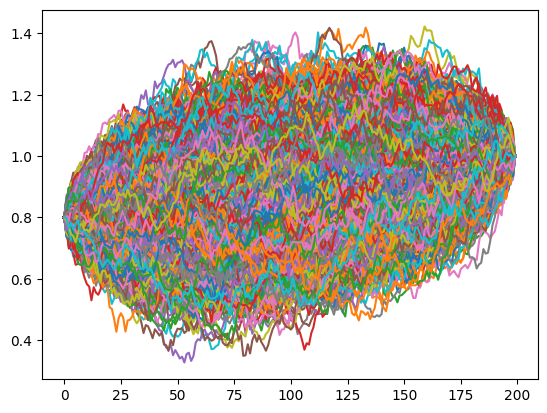

In [313]:
plt.plot(X)
plt.show()

In [307]:
W

array([[ 8.00000000e-01,  1.60000000e+00,  2.40000000e+00, ...,
         1.59840000e+03,  1.59920000e+03,  1.60000000e+03],
       [ 9.33818378e-03,  2.50700453e-02,  3.87286645e-02, ...,
         8.20720735e-01,  8.07654198e-01,  8.05230233e-01],
       [-7.19666109e-03, -4.74192326e-03, -5.90978703e-03, ...,
         1.02792863e+00,  1.02990576e+00,  1.04870870e+00],
       ...,
       [-2.00637987e-02, -2.14846648e-02, -6.26954439e-03, ...,
        -8.33402806e-01, -8.21145073e-01, -8.62658884e-01],
       [-3.04938272e-02, -2.19269602e-03, -3.76023540e-02, ...,
         6.46562437e-01,  6.46059893e-01,  6.19423762e-01],
       [ 1.41855709e-02,  3.91012305e-02,  4.71458092e-02, ...,
         2.43420417e-01,  2.53913684e-01,  2.87746521e-01]])

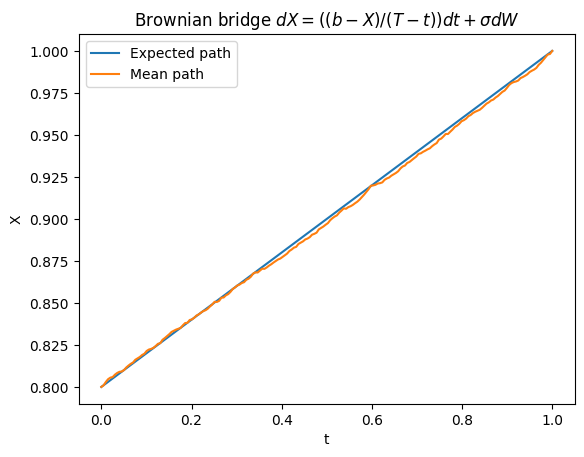

In [318]:
EX = a + (b-a)/T*t
plt.plot(t, EX)
plt.plot(t, np.mean(X, axis=1))
plt.legend(['Expected path','Mean path'])
plt.xlabel('t')
plt.ylabel('X')
plt.title('Brownian bridge $dX = ((b-X)/(T-t))dt + \\sigma dW$')
plt.show()

## Heston Stochastic Volatility Model

The dynamics of log-price $s_t = \ln S_t$.
$$ ds_t = \left(\mu - \frac{1}{2}v_t\right)dt + \sqrt{v_t}dW_t^s$$
$$ dv_t = k(\theta - v_t)dt + \varepsilon\sqrt{v_t}dW_t^v$$

In [340]:
mu = 0.03
theta = 0.05
k = 5
V_0 = 0.05
S_0 = 1
rho = 0.8
epsilon = 0.008

npaths = 10
nsteps = 100
T = 1
dt = T/nsteps

$$s_{t+1} = s_t + (\mu - v_t/2)dt + \sqrt{v_t}\left(\rho Z_1 + \sqrt{1 - \rho^2}Z_2\right)\sqrt{dt}$$
$$v_{t+1} = v_t + k(\theta - v_t)dt + \sqrt{\varepsilon}Z_1\sqrt{dt}$$

In [344]:
Z_1 = np.random.normal(size=(nsteps, npaths))
Z_2 = np.random.normal(size=(nsteps, npaths))
s = np.empty(shape=(nsteps, npaths))
s[0,:] = S_0
v = np.empty(shape=(nsteps, npaths))
v[0,:] = V_0

for i in range(nsteps-1):
    s[i+1,:] = s[i,:] + (mu - v[i,:]/2)*dt + sqrt(v[i,:])*(rho*Z_1[i,:] + sqrt(1 - rho**2)*Z_2[i,:])*sqrt(dt)
    v[i+1,:] = v[i,:] + k*(theta - v[i,:])*dt + sqrt(epsilon)*Z_1[i,:]*sqrt(dt)
    s[i+1,:] = np.maximum(s[i+1,:], 0)
    v[i+1,:] = np.maximum(v[i+1,:], 0)

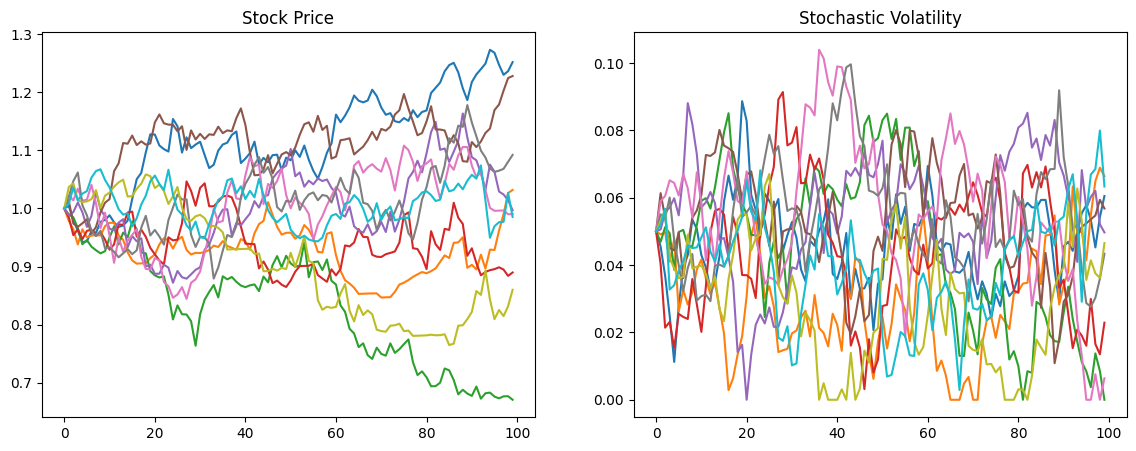

In [352]:
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].plot(s)
axes[0].set_title("Stock Price")
axes[1].plot(v)
axes[1].set_title("Stochastic Volatility")
plt.show()

## Merton Jump-Diffusion Model
$$ X_t = (\mu_S-0.5\sigma^2)t + \sigma W_t + \sum_{i=1}^{N_t} Z_i
$$

In [5]:
npaths = 20000
T = 1
nsteps = 200
dt = T/nsteps
t = np.linspace(0,T,nsteps)
# Parameters of the diffusion part (GBM).
muS = 0.2
sigmaS = 0.3

# Parameters of the jump part (NCPP)
S_0 = 1
muJ = -0.1
sigmaJ = 0.15
lam = 0.5

In [6]:
# Monte Carlo
# Compute the increments of the ABM.
dW = (muS-0.5*sigmaS**2)*dt + sigmaS*sqrt(dt)*rm.normal(size=(nsteps,npaths))

# Compute the increments of the NCPP.
dN = rm.poisson(lam*dt, size=(nsteps,npaths))
dJ = muJ*dN + sigmaJ*sqrt(dN)*rm.normal(size=(nsteps,npaths))

# Sum the increments of the ABM and the NCPP
dX = dW + dJ
#dX = np.vstack([np.full(shape=(1, npaths), fill_value=S_0), dX[:-1,:]])
X = np.cumsum(dX, axis=0)

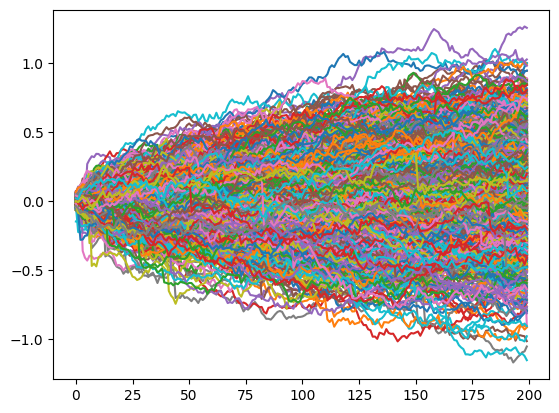

In [4]:
plt.plot(X)
plt.show()

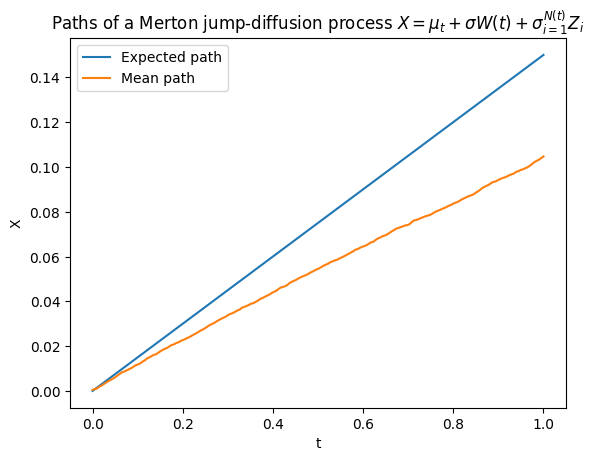

In [13]:
# Stock price
S = S_0*np.exp(X)

# Expected, mean and sample path
EX = (muS+lam*muJ)*t # expected path
plt.plot(t, EX)
plt.plot(t, np.mean(X, axis=1))
plt.legend(['Expected path','Mean path'])
plt.xlabel('t')
plt.ylabel('X')
plt.title('Paths of a Merton jump-diffusion process $X = \\mu_t + \\sigma W(t) + \\sigma_{i=1}^{N(t)} Z_i$')
plt.show()

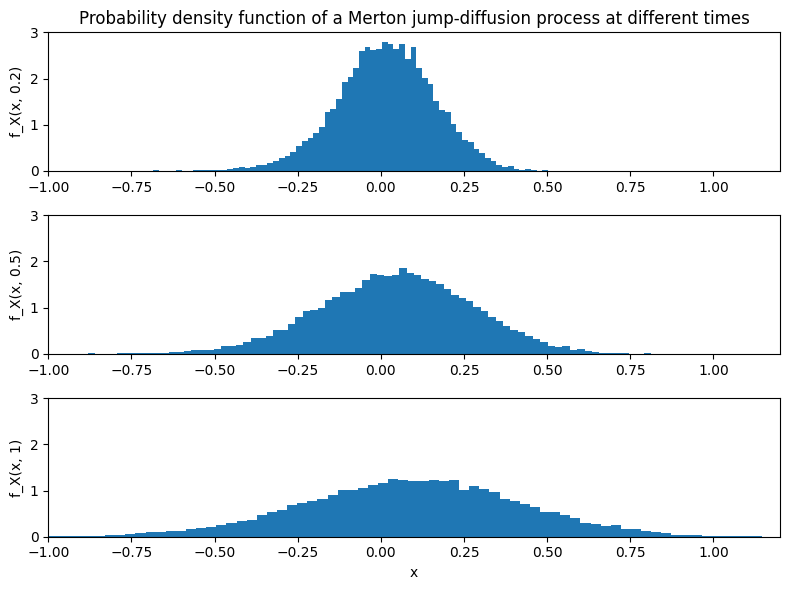

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Probability density function at different times
plt.figure(figsize=(8, 6))

# Time = 0.2
hist_1, bins_1 = np.histogram(X[40, :], bins=100)
f_1 = hist_1 / (np.sum(hist_1) * (bins_1[1] - bins_1[0]))
plt.subplot(3, 1, 1)
plt.bar(bins_1[:-1], f_1, width=(bins_1[1] - bins_1[0]))
plt.ylabel('f_X(x, 0.2)')
plt.xlim([-1, 1.2])
plt.ylim([0, 3])
plt.title('Probability density function of a Merton jump-diffusion process at different times')

# Time = 0.5
hist_2, bins_2 = np.histogram(X[100, :], bins=100)
f_2 = hist_2 / (np.sum(hist_2) * (bins_2[1] - bins_2[0]))
plt.subplot(3, 1, 2)
plt.bar(bins_2[:-1], f_2, width=(bins_2[1] - bins_2[0]))
plt.xlim([-1, 1.2])
plt.ylim([0, 3])
plt.ylabel('f_X(x, 0.5)')

# Time = 1
hist_3, bins_3 = np.histogram(X[-1, :], bins=100)
f_3 = hist_3 / (np.sum(hist_3) * (bins_3[1] - bins_3[0]))
plt.subplot(3, 1, 3)
plt.bar(bins_3[:-1], f_3, width=(bins_3[1] - bins_3[0]))
plt.xlim([-1, 1.2])
plt.ylim([0, 3])
plt.xlabel('x')
plt.ylabel('f_X(x, 1)')

plt.tight_layout()
plt.show()

## Asymmetric double-sided exponential distribution

$$ X(t)=\mu t+\sigma W(t)+\sum^{Po(t)}Z_k$$
$$Z_k \sim \exp(\rho, \eta_1, \eta_2)$$
$$ f_Z(z) = \rho\eta_1e^{−\eta_1z}1_{(z\ge0)} + (1 − \rho)\eta_2e^{\eta_2z}1_{(z<0)}, \eta_1, \eta_2 > 0, p \in \left[0, 1\right]$$

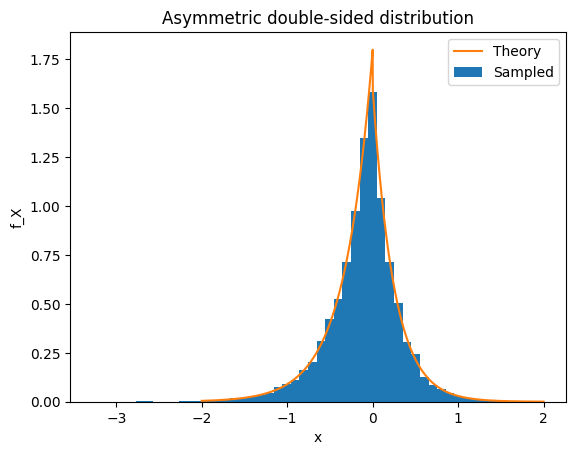

In [461]:
eta1 = 4
eta2 = 3
p = 0.4
xmax = 2
deltax = 0.01
n = 2*xmax/deltax
binw = 0.1
n = 10**4 # number of random samples

# Compute the PDF and sample the distribution.
x = np.linspace(-xmax, xmax, n)
f_X = p*eta1*np.exp(-eta1*x)*(x>=0) + (1-p)*eta2*np.exp(eta2*x)*(x<0) # PDF

U = rm.uniform(size=(1,n)) # standard uniform random variable.
X = -1/eta1*np.log((1-U)/p)*(U>=1-p)+1/eta2*np.log(U/(1-p))*(U<1-p) # bilateral exp. r.v.

plt.hist(X.flatten(), density=True, bins=50)
plt.plot(x, f_X)
plt.xlabel('x')
plt.ylabel('f_X')
plt.legend(['Theory', "Sampled"])
plt.title('Asymmetric double-sided distribution')
plt.show()

## Variance-Gamma Process

This is a time-changed arithmetic brownian motion:
$$ dX_t = \mu dG_t + \sigma dW(G_t)
$$

If $G_t = t$ then we go back to the typical case of brownian motion. Whereas, when it is different e.g. a gamma process, the process obviously changes.

In [462]:
npaths = 2000
T = 1
nsteps = 200
dt = T/nsteps
t = np.linspace(0,T,nsteps)
# Model parameters of the ABM.
mu = 0.2
sigma = 0.3
kappa = 0.05 # scale parameter of the gamma process = 1/beta = 1/rate.

In [466]:
# Monte Carlo
# Compute the increments of the gamma process.
dG = rm.gamma(dt/kappa,kappa,size=(nsteps,npaths))

# Compute the increments of the ABM on the gamma random clock.
dX = mu*dG + sigma*rm.normal(size=(nsteps,npaths))*sqrt(dG)

# Accumulate the increments.
X = np.cumsum(dX, axis=0)

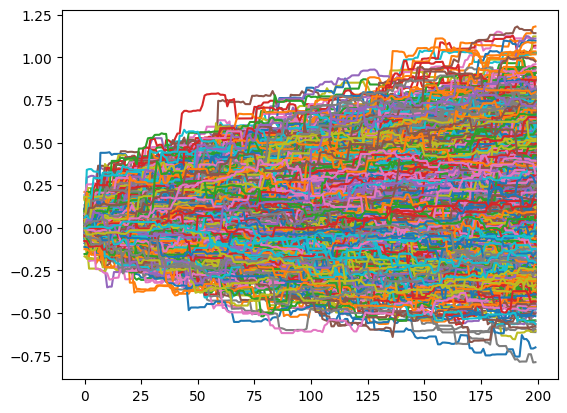

In [468]:
plt.plot(X)
plt.show()

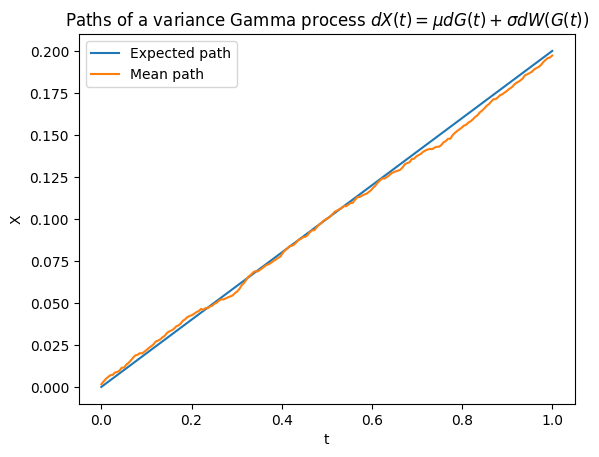

In [471]:
# Expected, mean and sample path
EX = mu*t
plt.plot(t, EX)
plt.plot(t, np.mean(X, axis=1))
plt.legend(['Expected path','Mean path'])
plt.xlabel('t')
plt.ylabel('X')
plt.title('Paths of a variance Gamma process $dX(t) = \\mu dG(t) + \\sigma dW(G(t))$')
plt.show()